pitch detection test with different sampling rates, block sizes etc.

# Setup

In [57]:
import time
import numpy as np
import scipy
import pya
import matplotlib.pyplot as plt

In [58]:
server = pya.Aserver(bs=1024)  
pya.Aserver.default = server  # set default Aserver to use play() w/o explicit arg
server.boot()

AServer: sr: 44100, blocksize: 1024,
         Stream Active: True, Device: Built-in Output, Index: 1

# Definitions

In [59]:
def create_test_signal(duration, frequency, signal_amp, noise_amp, sample_rate = 44100):
    """Creates a test signal, consisting of a singel sine-wave of given frequency + noise."""

    signal = pya.Ugen().sine(freq=frequency, amp=signal_amp, dur=duration, sr=sample_rate)
    noise = pya.Ugen().noise(type="pink", amp=1, dur=duration, sr=sample_rate).norm(2)
    noise += pya.Asig(-1 * np.ones(int(duration) * sample_rate), sr=sample_rate)
    noise *= noise_amp
    # it's very annoying that the noise (both types of noise) are not centered around zero...
    
    return signal + noise

In [60]:
def analyse_signal(signal, sample_rate = 44100, low_cut = 90, high_cut = 15000, plot=False, fft_alg = 3):
    """Finds prominent frequencies in a given Signal.
    
    Parameters
    ----------
    signal: np.array
        The signal to be analysed
    sample_rate: int
        The sample rate of the signal to be analysed
    low_cut: int
        The lowest frequency (in Hz) to be included in the analysis. (Default value = 90)
    high_cut: int
        The highest frequency (in Hz) to be included in the analysis. (Default value = 15000)
    plot: bool
        If plot is True, the spectrum of the analysed signal will be plotted. (Default value = False)
    fft_alg: 1, 2 or 3
        The implementation of the fast fourier transformation to be used for the analysis.
        1: np.fft.rfft
        2: np.fft.hfft
        3: scipy.fftpack.rfft
        
    Returns
    -------
    peaks_freq: list of floats
        A list of the approximated frequencies of the ten most prominent peaks, sorted by prominence.
    peaks_amp: list of floats
        A list of the approximated volumes of the ten most prominent peaks, sorted by prominence.
    
    """
    nr_samples = signal.size
    
    if fft_alg == 1:
        index_to_freq_factor = sample_rate / nr_samples
        low_i = int(low_cut / index_to_freq_factor)
        high_i = int(high_cut / index_to_freq_factor)
        spectrum = np.abs(np.fft.rfft(signal)[low_i:high_i]) / nr_samples * 2
    elif fft_alg == 2:
        index_to_freq_factor = 0.5 * sample_rate / nr_samples
        low_i = int(low_cut / index_to_freq_factor)
        high_i = int(high_cut / index_to_freq_factor)
        spectrum = np.abs(np.fft.hfft(signal)[low_i:high_i]) / nr_samples * 2
    elif fft_alg == 3:
        index_to_freq_factor = 0.5 * sample_rate / nr_samples
        low_i = int(low_cut / index_to_freq_factor)
        high_i = int(high_cut / index_to_freq_factor)
        # set overwrite_x True if you don't need the signal afterwards to be even faster!
        spectrum = np.abs(scipy.fftpack.rfft(signal, overwrite_x=False)[low_i:high_i]) / nr_samples * 2
    
    if plot:
        plt.plot(np.linspace(low_cut, high_cut, high_i - low_i), spectrum)
    
    peaks, _ = scipy.signal.find_peaks(spectrum)
    prominences = scipy.signal.peak_prominences(spectrum, peaks)[0]
    most_prominent = peaks[sorted(range(prominences.size), key=lambda i: - prominences[i])[:10]]
    peaks_amp = spectrum[most_prominent]
    peaks_freq = (most_prominent + low_i) * index_to_freq_factor
    return peaks_freq, peaks_amp

In [69]:
def evaluate_analyser(fft_alg,
                      min_dur_factor = 1, max_duration_factor = 30,
                      sample_rate = 44100, downsample_factors = [1,2,4,8], runs_per_dur = 3,
                      test_recording = "audio_files/recording-20190730-082916_amp.wav",
                      signal_freq = 349.91, signal_amp = 0.008616,
                      signal_noise_ratio = 0.2):
    """Evaluates the performance of the analyse_signal function
    The functions measures the computation time, the frequency error and the volume error for every duration and
    every downsample facor.
    
    Frequency error is the difference between signal_freq and the closest frequency in the tenmost
    prominent found frequencies, volume error is the difference between signal_amp (or
    signal_noise_ratio / (1 + signal_noise_ratio) for synthesized signals) and the sum of all of the ten most 
    prominent frequencies that are not more than 10 Hz away from signal_freq.
    
    The time needed for the fft depends heavily on the factorization of the number of samples
    so just testing durations in np.linspace(min_dur, max_dur, nr_runs) is not an option.
    To controll the factorization of the number of samples, I test durations in
    [2**12 * i / sample_rate for i in range(min_dur_factor,max_dur_factor)].
    For the default values, this yealds 30 durations from ca 0.1 to 2.8 seconds.
    
    Parameters
    ----------
    fft_alg: 1, 2 or 3
        The implementation of the fast fourier transformation to be used for the analysis.
        1: np.fft.rfft
        2: np.fft.hfft
        3: scipy.fftpack.rfft
    min_dur_factor: int
        The minimum Duration to be analysed is 2**12 * min_dur_factor / sample_rate. (Default value = 1)
    max_duration_factor: int
        The maximum Duration to be analysed is 2**12 * min_dur_factor / sample_rate. (Default value = 30)
    sample_rate: int
        The sample rate of the signal to be analysed.
    downsample_factors: list
        A list of the downsample factors to be tested for each duration. (Default value = [1,2,4,8])
    runs_per_dur: int
        The number of test runs for every duration and every downsample factor. (Default value = 3)
    test_recording: None or String
        If a path to a wav recording is given, this recording is analysed,
        if None is given, a synthetic Signal is synthesized with create_test_signal.
        (Default value = "audio_files/recording-20190730-082916_amp.wav", a recording of my humming guitar amp)
    signal_freq: float
        Most prominent frequency of the recording or (if test_recording is None) the frequency of the 
        sine wave of the synthesized signal.
        (Default value = 349.91, most prominent frequency of my humming amp)
    signal_amp: float
        The volume of the most prominent frequency of the recording or (only test_recording is not None).
        (Default value = 0.008616, volume of most prominent frequency of my humming amp)
    signal_noise_ratio:
        The volume to noise ratio of the synthsized signal (only if test_recordning is None). (Default value = 0.2)
    
    Returns
    -------
    results: a dictionary of dictionarys
        A dictionary for every given downsample factors that contains:
        A list of tested durations,
        A list of computation times for each tested duration,
        The standard deviations per the run for each of those times,
        A list of frequency errors for each tested duration,
        A list of errors in volume for each tested duration.
    """

    results = {i: {'durations': [], 'times': [], 'time sd': [], 'freq errors': [], 'amp errors': []}
               for i in downsample_factors}

    for nr_samples in [2**12 * i for i in range(min_dur_factor, max_duration_factor + 1)]:
        dur = nr_samples / sample_rate

        if test_recording is None:
            signal_amp = signal_noise_ratio / (1 + signal_noise_ratio)
            noise_amp = 1 / (1 + signal_noise_ratio)
            signal = create_test_signal(dur, signal_freq, signal_amp, noise_amp)
        else:
            signal = pya.Asig(test_recording, label='test_recording')[3*nr_samples:4*nr_samples].mono()

        for i in results:
            if i > 1:
                sample_rate_local = sample_rate // i
                s = signal.resample(target_sr=sample_rate_local)
            else:
                sample_rate_local = sample_rate
                s = signal

            times = []
            freq_errors = []
            amp_errors = []
            for _ in range(runs_per_dur):
                start = time.time()
                freqs, amps = analyse_signal(s.sig, sample_rate=sample_rate_local, fft_alg=fft_alg)
                times.append(time.time() - start)

                freq_errors.append(min([abs(signal_freq - f) for f in freqs]))

                good_amps = [amps[i] for i in range(len(freqs)) if abs(signal_freq - freqs[i]) < 10]
                if len(good_amps) > 0:
                    amp_errors.append(abs(signal_amp - sum(good_amps)))
                else:
                    amp_errors.append(1)
            results[i]['durations'].append(dur)
            results[i]['times'].append(np.mean(times))
            results[i]['time sd'].append(np.std(times))
            results[i]['freq errors'].append(np.mean(freq_errors))
            results[i]['amp errors'].append(np.mean(amp_errors))
            
    return results

# Evaluation

In [84]:
# scipy.fftpack.rfft has some strange computation times:
# for some reason i = 23 yealds an extremely high time (16 s) and I have no idea why
# similar i = 15 yealds an moderately high time for downsample 4 and I have no idea why
# (both for default evaluation values)

# np.fft.hfft is similar to scipy.fftpack.rfft without strange computation times

# np.fft.rfft is by far the fastest, less inexplicable peaks and fastest convergence to low errors!

results = evaluate_analyser(fft_alg=1, min_dur_factor=6)

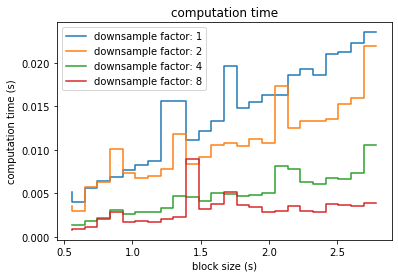

In [85]:
fig, ax = plt.subplots()

for i in results:
    ax.step(results[i]['durations'], results[i]['times'], label="downsample factor: %i" % i)

ax.set(xlabel='block size (s)', ylabel='computation time (s)',
       title='computation time')
ax.legend()

#fig.savefig("test.png")
plt.show()

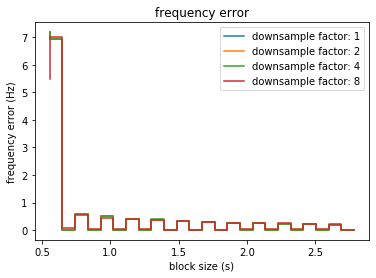

In [86]:
fig, ax = plt.subplots()

for i in results:
    ax.step(results[i]['durations'], results[i]['freq errors'], label="downsample factor: %i" % i)

ax.set(xlabel='block size (s)', ylabel='frequency error (Hz)',
       title='frequency error')
ax.legend()

#fig.savefig("test.png")
plt.show()

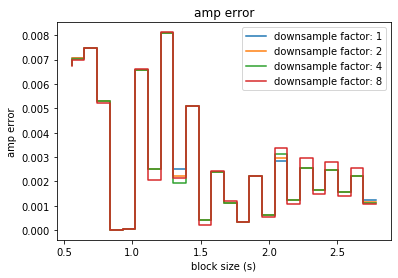

In [87]:
fig, ax = plt.subplots()

for i in results:
    ax.step(results[i]['durations'], results[i]['amp errors'], label="downsample factor: %i" % i)

ax.set(xlabel='block size (s)', ylabel='amp error',
       title='amp error')
ax.legend()

#fig.savefig("test.png")
plt.show()


1.5789569160997732
0.2


(array([ 1000.02728631,  2001.32123162,  7456.18824678, 10286.53779871,
         4582.1389591 , 13392.38568474,  9006.57887178, 11570.93003217,
        10626.63574219, 14020.01522289]),
 array([0.19888609, 0.13848724, 0.0161139 , 0.01581509, 0.01539372,
        0.01470204, 0.01465726, 0.01452725, 0.01441892, 0.01418972]))

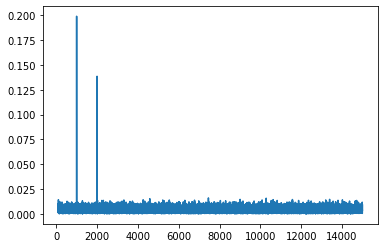

In [88]:
# manual test
# looks like measured intensity of sine depends heavily on the relation of frequency of sine and duration
# for i = 17, freq = 1000, 2000, 3000, 4000 allmost no error
# but for i = 17, freq = 1001, 2001 etc. high error!
# This result does not even fanish for giant blocksize like i=441*5 , dur = 204.8 sec!
i = 17
dur = 2**12 * i / 44100
print(dur)
#dur = 2.0
#signal_noise_ratio = 1 / 14
signal_freq = 1000
signal_amp = 0.2 # signal_noise_ratio / (1 + signal_noise_ratio)
print(signal_amp)
noise_amp = 0.8 #1 / (1 + signal_noise_ratio)
signal = create_test_signal(dur, signal_freq, signal_amp, noise_amp) + create_test_signal(dur, 2001, 0.2, noise_amp)
analyse_signal(signal.sig, plot=True, fft_alg=1)

2.6006349206349206


(array([ 349.91455078,  249.93896484,  449.89013672,  649.84130859,
         749.81689453, 1350.05493164,  149.96337891, 1450.03051758,
        1749.95727539, 1050.12817383]),
 array([0.00705141, 0.0067077 , 0.00646068, 0.00278941, 0.00250887,
        0.00213524, 0.00181693, 0.00115382, 0.00102732, 0.00094502]))

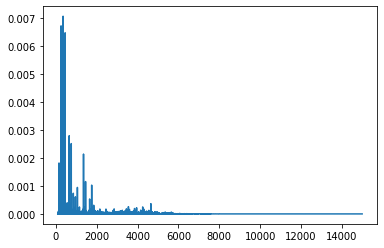

In [89]:
# manual test with recorded noise
i = 28
nr_samples = 2**12 * i
sample_rate = 44100
dur = nr_samples / sample_rate
print(dur)
signal_freq = 349.91455078  # identified as dominant frequency when i = 28 for alg 1, i = 34 for alg 2,3
signal_amp = 0.00861599
signal = pya.Asig("audio_files/recording-20190730-082916_amp.wav", label='amp')[3*nr_samples:4*nr_samples].mono()
analyse_signal(signal.sig, plot=True, fft_alg=1)